# 1. Import các package cần thiết

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# đặt lại seed để đảm bảo tính tái lập
np.random.seed(42)
tf.random.set_seed(42)

# 2. Đọc & khám phá dữ liệu

In [3]:
df = pd.read_csv('../data/kidney_disease_ckd.csv')
df.head() #hiển thị 5 dòng đầu tiên của dataframe

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,90.0,160.0,1.017,0.0,3.0,normal,normal,not present,not present,...,49.0,6745.0,3.0,no,no,yes,poor,yes,yes,notckd
1,1,57.0,131.0,1.016,5.0,5.0,normal,normal,not present,present,...,43.0,7594.0,4.5,no,no,yes,good,no,no,notckd
2,2,34.0,158.0,1.017,3.0,4.0,abnormal,normal,present,not present,...,37.0,10103.0,5.0,no,no,yes,poor,yes,no,notckd
3,3,35.0,106.0,1.023,0.0,2.0,normal,abnormal,present,present,...,48.0,4794.0,3.5,yes,yes,no,good,no,yes,notckd
4,4,16.0,155.0,1.024,0.0,3.0,abnormal,normal,not present,not present,...,28.0,7693.0,3.2,yes,no,no,poor,yes,yes,notckd


In [4]:
#kiểm tra phân bố lớp mục tiêu
df['classification'].value_counts()
df['classification'].value_counts(normalize=True)

classification
ckd       0.570488
notckd    0.429512
Name: proportion, dtype: float64

# 3. Tiền xử lý dữ liệu

In [5]:
#xoá cột 'id' không cần thiết
df = df.drop('id', axis=1)

In [6]:
# danh sách các cột phân loại
categorical_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

In [7]:
# làm sạch dữ liệu trong các cột phân loại
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.replace('\t', '')
        
df = df.replace(['?', '\t?', ' ?'], np.nan)

In [8]:
# xử lý cột 'classification'
df['classification'] = df['classification'].str.strip()
df['classification'] = df['classification'].astype(str).str.lower()
df['classification'] = df['classification'].str.strip()
df['classification'] = df['classification'].str.replace('\t', '', regex=False)

print(df['classification'].unique())

valid_classes = ['ckd', 'notckd']
df = df[df['classification'].isin(valid_classes)].copy()

label_map = {'notckd': 0, 'ckd': 1}
df['classification'] = df['classification'].map(label_map).astype(int)

print("Giá trị nhãn sau khi mã hóa:", df['classification'].unique())


['notckd' 'ckd']
Giá trị nhãn sau khi mã hóa: [0 1]


In [9]:
# lấy danh sách các cột số
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in df.select_dtypes(include=[np.number]).columns
                  if col != 'classification']

In [10]:
# điền giá trị thiếu trong các cột số bằng trung vị
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_9316\453413192.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_9316\453413192.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

In [11]:
# mã hóa nhãn cho các cột phân loại
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

# 4. Tách nhãn và chia tập dữ liệu

In [12]:
# tách đặc trưng và nhãn mục tiêu
X = df.drop('classification', axis=1)
y = df['classification']

In [13]:
# chia tập dữ liệu thành tập huấn luyện, tập xác thực và tập kiểm tra
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765,       
    random_state=42,
    stratify=y_temp
)

In [14]:
# chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# 6. Xây dựng kiến trúc ANN

In [15]:
# Tạo mô hình ANN
def create_ann_model(input_dim):#tang them 1 hiden layer, chuyen ham kich hoat ở các hidden layer tu relu sang LeakyReaLU, them BatchNormalization
    model = Sequential([
        Dense(128, kernel_initializer='he_normal', input_shape=(input_dim,)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),

        Dense(64, kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        Dense(32, kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),

        Dense(1, activation='sigmoid')
    ])
    return model

# Tạo mô hình
model = create_ann_model(X_train_scaled.shape[1])

# Xem kiến trúc model
model.summary()


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,017 (54.75 KB)

 Non-trainable params: 448 (1.75 KB)

# 7. Biên dịch mô hình

In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.0005), #0.001->0.0005
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# 8. Thiết lập callback

In [17]:
# dừng sớm
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
# lưu mô hình tốt nhất dựa trên độ chính xác xác thực
model_checkpoint = ModelCheckpoint(
    '../model/best_kidney_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
callbacks = [early_stopping, model_checkpoint]

# 9. Huẩn luyện mô hình

In [18]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,# 50->100
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
54/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5125 - loss: 0.8026 - precision: 0.6689 - recall: 0.2913

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5530 - loss: 0.7649 - precision: 0.7038 - recall: 0.3733 - val_accuracy: 0.5543 - val_loss: 0.7300 - val_precision: 0.7755 - val_recall: 0.3077
Epoch 2/100
58/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5919 - loss: 0.6990 - precision: 0.7029 - recall: 0.4987

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5970 - loss: 0.6914 - precision: 0.6899 - recall: 0.5330 - val_accuracy: 0.6097 - val_loss: 0.6498 - val_precision: 0.7097 - val_recall: 0.5344
Epoch 3/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6046 - loss: 0.6772 - precision: 0.6707 - recall: 0.6088

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6233 - loss: 0.6603 - precision: 0.6822 - recall: 0.6354 - val_accuracy: 0.6236 - val_loss: 0.6211 - val_precision: 0.6707 - val_recall: 0.6680
Epoch 4/100
55/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6235 - loss: 0.6529 - precision: 0.6692 - recall: 0.6763

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6144 - loss: 0.6466 - precision: 0.6604 - recall: 0.6667 - val_accuracy: 0.6467 - val_loss: 0.6091 - val_precision: 0.6767 - val_recall: 0.7287
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6386 - loss: 0.6251 - precision: 0.6735 - recall: 0.7109 - val_accuracy: 0.6420 - val_loss: 0.6022 - val_precision: 0.6716 - val_recall: 0.7287
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6272 - loss: 0.6188 - precision: 0.6621 - recall: 0.7075 - val_accuracy: 0.6397 - val_loss: 0.5969 - val_precision: 0.6643 - val_recall: 0.7449
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6450 - loss: 0.6122 - precision: 0.6750 - recall: 0.7283 - val_accuracy: 0.6420 - val_loss: 0.5930 - val_precision: 0.6655 - val_recall: 0.7490
Epoch 8/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6496 - loss: 0.6200 - precision: 0.6863 - recall: 0.7151

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6525 - loss: 0.6121 - precision: 0.6853 - recall: 0.7222 - val_accuracy: 0.6490 - val_loss: 0.5887 - val_precision: 0.6655 - val_recall: 0.7733
Epoch 9/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6581 - loss: 0.6066 - precision: 0.6871 - recall: 0.7398

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6649 - loss: 0.6058 - precision: 0.6911 - recall: 0.7457 - val_accuracy: 0.6559 - val_loss: 0.5875 - val_precision: 0.6701 - val_recall: 0.7814
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6693 - loss: 0.5963 - precision: 0.6977 - recall: 0.7413 - val_accuracy: 0.6559 - val_loss: 0.5844 - val_precision: 0.6725 - val_recall: 0.7733
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6550 - loss: 0.5922 - precision: 0.6816 - recall: 0.7413 - val_accuracy: 0.6513 - val_loss: 0.5829 - val_precision: 0.6678 - val_recall: 0.7733
Epoch 12/100
56/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6776 - loss: 0.5911 - precision: 0.7035 - recall: 0.7543

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6653 - loss: 0.5916 - precision: 0.6932 - recall: 0.7413 - val_accuracy: 0.6582 - val_loss: 0.5786 - val_precision: 0.6787 - val_recall: 0.7611
Epoch 13/100
56/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6734 - loss: 0.5905 - precision: 0.7075 - recall: 0.7333

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6738 - loss: 0.5863 - precision: 0.7049 - recall: 0.7361 - val_accuracy: 0.6651 - val_loss: 0.5752 - val_precision: 0.6809 - val_recall: 0.7773
Epoch 14/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6743 - loss: 0.5732 - precision: 0.7051 - recall: 0.7370 - val_accuracy: 0.6513 - val_loss: 0.5734 - val_precision: 0.6678 - val_recall: 0.7733
Epoch 15/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6876 - loss: 0.5697 - precision: 0.7221 - recall: 0.7352 - val_accuracy: 0.6559 - val_loss: 0.5711 - val_precision: 0.6701 - val_recall: 0.7814
Epoch 16/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6832 - loss: 0.5807 - precision: 0.7114 - recall: 0.7523

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6851 - loss: 0.5802 - precision: 0.7115 - recall: 0.7535 - val_accuracy: 0.6674 - val_loss: 0.5704 - val_precision: 0.6820 - val_recall: 0.7814
Epoch 17/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6752 - loss: 0.5756 - precision: 0.7067 - recall: 0.7361 - val_accuracy: 0.6536 - val_loss: 0.5712 - val_precision: 0.6690 - val_recall: 0.7773
Epoch 18/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6946 - loss: 0.5726 - precision: 0.7246 - recall: 0.7491 - val_accuracy: 0.6582 - val_loss: 0.5700 - val_precision: 0.6749 - val_recall: 0.7733
Epoch 19/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6842 - loss: 0.5687 - precision: 0.7142 - recall: 0.7439 - val_accuracy: 0.6582 - val_loss: 0.5693 - val_precision: 0.6749 - val_recall: 0.7733
Epoch 20/100
58/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7047 - loss: 0.5631 - precision: 0.7324 - recall: 0.7641

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7050 - loss: 0.5620 - precision: 0.7344 - recall: 0.7561 - val_accuracy: 0.6697 - val_loss: 0.5658 - val_precision: 0.6884 - val_recall: 0.7692
Epoch 21/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7094 - loss: 0.5542 - precision: 0.7368 - recall: 0.7630 - val_accuracy: 0.6697 - val_loss: 0.5658 - val_precision: 0.6871 - val_recall: 0.7733
Epoch 22/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7089 - loss: 0.5583 - precision: 0.7414 - recall: 0.7517 - val_accuracy: 0.6536 - val_loss: 0.5644 - val_precision: 0.6726 - val_recall: 0.7652
Epoch 23/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7079 - loss: 0.5499 - precision: 0.7300 - recall: 0.7743 - val_accuracy: 0.6674 - val_loss: 0.5622 - val_precision: 0.6782 - val_recall: 0.7935
Epoch 24/100
56/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7218 - loss: 0.5427 - precision: 0.7557 - recall: 0.7632

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7183 - loss: 0.5445 - precision: 0.7443 - recall: 0.7708 - val_accuracy: 0.6744 - val_loss: 0.5622 - val_precision: 0.6920 - val_recall: 0.7733
Epoch 25/100
55/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7034 - loss: 0.5515 - precision: 0.7355 - recall: 0.7541

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7099 - loss: 0.5480 - precision: 0.7402 - recall: 0.7569 - val_accuracy: 0.6790 - val_loss: 0.5609 - val_precision: 0.6985 - val_recall: 0.7692
Epoch 26/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7050 - loss: 0.5466 - precision: 0.7376 - recall: 0.7491 - val_accuracy: 0.6628 - val_loss: 0.5622 - val_precision: 0.6823 - val_recall: 0.7652
Epoch 27/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7050 - loss: 0.5520 - precision: 0.7321 - recall: 0.7613 - val_accuracy: 0.6559 - val_loss: 0.5617 - val_precision: 0.6713 - val_recall: 0.7773
Epoch 28/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7109 - loss: 0.5387 - precision: 0.7367 - recall: 0.7674 - val_accuracy: 0.6674 - val_loss: 0.5589 - val_precision: 0.6846 - val_recall: 0.7733
Epoch 29/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7015 - loss: 0.5451 - precision: 0.7328 - recall: 0.7500 - val_accuracy: 0.6790 - val_loss: 0.5564 - val_pr

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7218 - loss: 0.5269 - precision: 0.7504 - recall: 0.7674 - val_accuracy: 0.6813 - val_loss: 0.5580 - val_precision: 0.6953 - val_recall: 0.7854
Epoch 33/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7317 - loss: 0.5197 - precision: 0.7598 - recall: 0.7743 - val_accuracy: 0.6813 - val_loss: 0.5563 - val_precision: 0.6968 - val_recall: 0.7814
Epoch 34/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7074 - loss: 0.5323 - precision: 0.7395 - recall: 0.7517 - val_accuracy: 0.6744 - val_loss: 0.5563 - val_precision: 0.6934 - val_recall: 0.7692
Epoch 35/100
57/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7246 - loss: 0.5301 - precision: 0.7566 - recall: 0.7666

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7282 - loss: 0.5224 - precision: 0.7575 - recall: 0.7700 - val_accuracy: 0.6882 - val_loss: 0.5547 - val_precision: 0.7000 - val_recall: 0.7935
Epoch 36/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7337 - loss: 0.5191 - precision: 0.7584 - recall: 0.7821 - val_accuracy: 0.6882 - val_loss: 0.5542 - val_precision: 0.6944 - val_recall: 0.8097
Epoch 37/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7178 - loss: 0.5216 - precision: 0.7454 - recall: 0.7674 - val_accuracy: 0.6697 - val_loss: 0.5507 - val_precision: 0.6831 - val_recall: 0.7854
Epoch 38/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7381 - loss: 0.5162 - precision: 0.7647 - recall: 0.7812 - val_accuracy: 0.6882 - val_loss: 0.5504 - val_precision: 0.7044 - val_recall: 0.7814
Epoch 39/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7424 - loss: 0.5195 - precision: 0.7722 - recall: 0.7796

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7411 - loss: 0.5116 - precision: 0.7718 - recall: 0.7752 - val_accuracy: 0.7044 - val_loss: 0.5486 - val_precision: 0.7148 - val_recall: 0.8016
Epoch 40/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7584 - loss: 0.4958 - precision: 0.7818 - recall: 0.7995 - val_accuracy: 0.6928 - val_loss: 0.5460 - val_precision: 0.7096 - val_recall: 0.7814
Epoch 41/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7366 - loss: 0.5098 - precision: 0.7636 - recall: 0.7795 - val_accuracy: 0.6928 - val_loss: 0.5474 - val_precision: 0.7080 - val_recall: 0.7854
Epoch 42/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7381 - loss: 0.5034 - precision: 0.7674 - recall: 0.7760 - val_accuracy: 0.6952 - val_loss: 0.5466 - val_precision: 0.7076 - val_recall: 0.7935
Epoch 43/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7446 - loss: 0.5049 - precision: 0.7695 - recall: 0.7882 - val_accuracy: 0.7021 - val_loss: 0.5455 - val_pr

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7475 - loss: 0.4898 - precision: 0.7707 - recall: 0.7934 - val_accuracy: 0.7159 - val_loss: 0.5462 - val_precision: 0.7279 - val_recall: 0.8016
Epoch 46/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7599 - loss: 0.4850 - precision: 0.7853 - recall: 0.7969 - val_accuracy: 0.7090 - val_loss: 0.5452 - val_precision: 0.7184 - val_recall: 0.8057
Epoch 47/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7450 - loss: 0.4885 - precision: 0.7697 - recall: 0.7891 - val_accuracy: 0.7067 - val_loss: 0.5462 - val_precision: 0.7190 - val_recall: 0.7976
Epoch 48/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7554 - loss: 0.4813 - precision: 0.7822 - recall: 0.7917 - val_accuracy: 0.7090 - val_loss: 0.5469 - val_precision: 0.7184 - val_recall: 0.8057
Epoch 49/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7599 - loss: 0.4833 - precision: 0.7843 - recall: 0.7986 - val_accuracy: 0.7067 - val_loss: 0.5487 - val_pr

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7827 - loss: 0.4429 - precision: 0.8081 - recall: 0.8116 - val_accuracy: 0.7182 - val_loss: 0.5387 - val_precision: 0.7256 - val_recall: 0.8138
Epoch 61/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7683 - loss: 0.4661 - precision: 0.7928 - recall: 0.8038 - val_accuracy: 0.7159 - val_loss: 0.5346 - val_precision: 0.7214 - val_recall: 0.8178
Epoch 62/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7748 - loss: 0.4550 - precision: 0.8033 - recall: 0.8012 - val_accuracy: 0.7159 - val_loss: 0.5352 - val_precision: 0.7183 - val_recall: 0.8259
Epoch 63/100
57/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7866 - loss: 0.4524 - precision: 0.8067 - recall: 0.8258

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7871 - loss: 0.4505 - precision: 0.8059 - recall: 0.8255 - val_accuracy: 0.7252 - val_loss: 0.5343 - val_precision: 0.7353 - val_recall: 0.8097
Epoch 64/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7723 - loss: 0.4511 - precision: 0.7988 - recall: 0.8030 - val_accuracy: 0.7229 - val_loss: 0.5336 - val_precision: 0.7326 - val_recall: 0.8097
Epoch 65/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7931 - loss: 0.4421 - precision: 0.8175 - recall: 0.8203 - val_accuracy: 0.7136 - val_loss: 0.5341 - val_precision: 0.7236 - val_recall: 0.8057
Epoch 66/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7752 - loss: 0.4509 - precision: 0.8024 - recall: 0.8038 - val_accuracy: 0.7159 - val_loss: 0.5324 - val_precision: 0.7214 - val_recall: 0.8178
Epoch 67/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7891 - loss: 0.4294 - precision: 0.8129 - recall: 0.8186 - val_accuracy: 0.7206 - val_loss: 0.5329 - val_pr

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8010 - loss: 0.4197 - precision: 0.8238 - recall: 0.8281 - val_accuracy: 0.7298 - val_loss: 0.5349 - val_precision: 0.7289 - val_recall: 0.8381
Epoch 73/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7985 - loss: 0.4252 - precision: 0.8270 - recall: 0.8177 - val_accuracy: 0.7229 - val_loss: 0.5380 - val_precision: 0.7292 - val_recall: 0.8178
Epoch 74/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7970 - loss: 0.4260 - precision: 0.8198 - recall: 0.8255 - val_accuracy: 0.7229 - val_loss: 0.5360 - val_precision: 0.7276 - val_recall: 0.8219
Epoch 75/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8054 - loss: 0.4224 - precision: 0.8197 - recall: 0.8446 - val_accuracy: 0.7275 - val_loss: 0.5409 - val_precision: 0.7232 - val_recall: 0.8462
Epoch 76/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7985 - loss: 0.4192 - precision: 0.8231 - recall: 0.8238 - val_accuracy: 0.7298 - val_loss: 0.5387 - val_pr

# 10. Đánh giá và lưu mô hình

In [19]:
# đánh giá mô hình trên tập test
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [20]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    X_test_scaled,
    y_test,
    verbose=0
)
test_f1 = f1_score(y_test, y_pred)
print("Unique labels in y:", sorted(y.unique()))
print("Unique labels in y_test:", sorted(y_test.unique()))

Unique labels in y: [np.int64(0), np.int64(1)]
Unique labels in y_test: [np.int64(0), np.int64(1)]


In [21]:
# in ra các chỉ số đánh giá
classification_report(y_test, y_pred, target_names=['Not CKD', 'CKD'])

'              precision    recall  f1-score   support\n\n     Not CKD       0.69      0.60      0.64       186\n         CKD       0.73      0.80      0.76       248\n\n    accuracy                           0.71       434\n   macro avg       0.71      0.70      0.70       434\nweighted avg       0.71      0.71      0.71       434\n'

<Axes: >

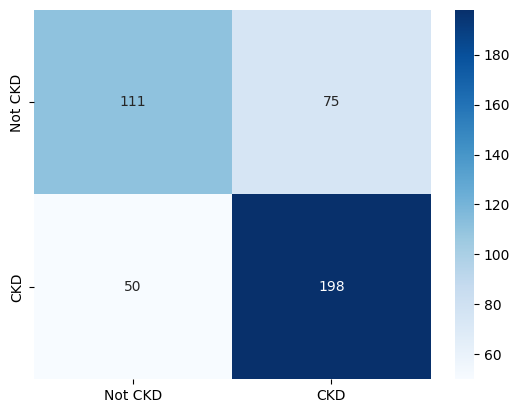

In [22]:
#  vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not CKD', 'CKD'], yticklabels=['Not CKD', 'CKD'])

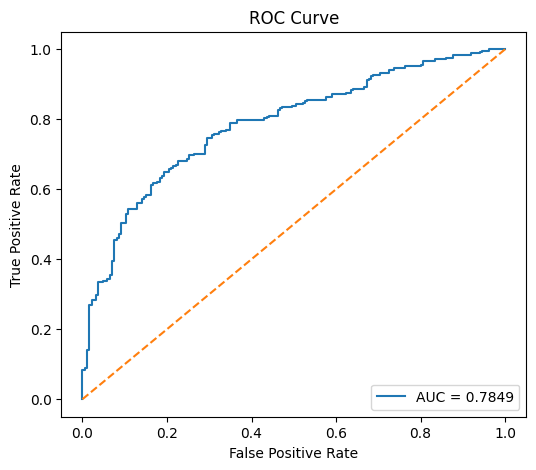

In [23]:
# Tính FPR, TPR và AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Vẽ biểu đồ
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")  # đường random
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [24]:
#  hàm dự đoán bệnh
def predict_kidney_disease(model, scaler, features):
    features_scaled = scaler.transform([features])
    probability = model.predict(features_scaled)[0][0]
    prediction = 1 if probability > 0.5 else 0
    return prediction, probability

In [25]:
# lưu mô hình và bộ scaler
model.save('../model/kidney_disease_model.h5')
joblib.dump(scaler, '../model/scaler.pkl')

['../model/scaler.pkl']